In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
###############
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xg
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

/kaggle/input/pucp-2023-01-fundamentos-de-aprendizaje-de-mquina/sample_submission.csv
/kaggle/input/pucp-2023-01-fundamentos-de-aprendizaje-de-mquina/test_x.csv
/kaggle/input/pucp-2023-01-fundamentos-de-aprendizaje-de-mquina/train.csv


# Read Df

In [2]:
train = pd.read_csv('/kaggle/input/pucp-2023-01-fundamentos-de-aprendizaje-de-mquina/train.csv', index_col = 'Id')

test = pd.read_csv('/kaggle/input/pucp-2023-01-fundamentos-de-aprendizaje-de-mquina/test_x.csv', index_col = 'Id')

In [3]:
train['Indice Satisfaccion'].value_counts() / train.shape[0]

1    0.633202
0    0.366798
Name: Indice Satisfaccion, dtype: float64

# Random Forest sin limpieza

In [4]:
train_x = train.drop(columns = ['Indice Satisfaccion'])
train_y = train['Indice Satisfaccion']

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=2023)
# Random forest
rf = RandomForestClassifier(random_state=2023)
model_rf = rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict_proba(x_val)
auc_rf = roc_auc_score(y_val, y_pred_rf[:,1])
print('auc RandomForest', auc_rf)

## Importancia de variables con RF
perm_imp = permutation_importance(model_rf, x_val, y_val, n_repeats=10, scoring='roc_auc')
df_imp = (pd.DataFrame({k:perm_imp[k] for k in ['importances_mean','importances_std']}, index=x_val.columns)
            .sort_values('importances_mean', ascending=False))

df_imp

auc RandomForest 0.8711159371867693


,importances_mean,importances_std
Grado de Colorante,0.151080,0.009165
Ingrediente_2,0.068401,0.005785
Azucar Gramos,0.035544,0.004254
Gramos de aspartamo,0.020852,0.003343
Gramos entre Azucar y otros endulcorantes,0.020407,0.001953
Densidad,0.016431,0.002961
Sodio en mg,0.016320,0.002228
Ingrediente_3,0.013440,0.002422
Ingrediente_1,0.010929,0.002471
Litros de Cafeina,0.006376,0.001780


# Extratree sin liempeza

In [5]:
train_x = train.drop(columns = ['Indice Satisfaccion'])
train_y = train['Indice Satisfaccion']

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=2023)
# Random forest

clf = ExtraTreesClassifier(random_state=2023)
xt_model = clf.fit(x_train, y_train)
y_pred_xt = xt_model.predict_proba(x_val)
auc_xt = roc_auc_score(y_val, y_pred_xt[:,1])
print('auc Extratree', auc_xt)

## Importancia de variables con RF
perm_imp = permutation_importance(xt_model, x_val, y_val, n_repeats=10, scoring='roc_auc')
df_imp = (pd.DataFrame({k:perm_imp[k] for k in ['importances_mean','importances_std']}, index=x_val.columns)
            .sort_values('importances_mean', ascending=False))

df_imp

auc Extratree 0.8730590676490759


,importances_mean,importances_std
Grado de Colorante,0.153457,0.008592
Ingrediente_2,0.058441,0.007434
Azucar Gramos,0.027899,0.002608
Gramos entre Azucar y otros endulcorantes,0.017479,0.002686
Sodio en mg,0.017077,0.002236
Densidad,0.014002,0.002133
Gramos de aspartamo,0.012534,0.001890
Ingrediente_3,0.010171,0.003665
Litros de Cafeina,0.006407,0.001513
Ingrediente_1,0.005670,0.001711


# Limpieza

## outliders

In [6]:
outlider_exceso = ['Ingrediente_1','Ingrediente_2','Ingrediente_3', 'Sodio en mg',
'Gramos de aspartamo', 'Azucar Gramos', 'Gramos entre Azucar y otros endulcorantes',
'Densidad', 'pH', 'Litros de Cafeina', 'Grado de Colorante'] 
# outlider_defecto = ['Ingrediente_1', 'Ingrediente_3']

# Define una funcion que encuentre todos los outliers por exceso
def out_exceso(df, columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr
    return (df[columna] > ul)

# Define una funcion que encuentre todos los outliers por defecto
def out_defecto(df, columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    ll = q1 - 1.5*iqr
    return (df[columna] < ll)

# for c in outlider_defecto:
#     train_x.loc[out_defecto(train_x, c), [c]] = train_x.loc[out_defecto(train_x, c)==False, c].min()
    
for i in outlider_exceso:
    train_x.loc[out_exceso(train_x, i), [i]] = train_x.loc[out_exceso(train_x, i)==False, i].max()

## Correlaciones

In [7]:
# mapa de correlacion de las variables cuantitativas
corr = train_x.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,Edad,Ingrediente_1,Ingrediente_2,Ingrediente_3,Sodio en mg,Gramos de aspartamo,Azucar Gramos,Gramos entre Azucar y otros endulcorantes,Densidad,pH,Litros de Cafeina,Grado de Colorante
Edad,1.00,-0.00,0.02,-0.01,-0.02,0.00,-0.00,0.00,-0.01,0.01,0.01,0.01
Ingrediente_1,-0.00,1.00,0.23,0.30,-0.09,0.42,-0.27,-0.31,0.47,0.28,0.28,-0.12
Ingrediente_2,0.02,0.23,1.00,-0.40,-0.20,0.52,-0.36,-0.42,0.28,0.25,0.25,-0.03
Ingrediente_3,-0.01,0.30,-0.40,1.00,0.14,-0.07,0.16,0.21,0.09,0.04,0.04,-0.01
Sodio en mg,-0.02,-0.09,-0.20,0.14,1.00,-0.16,0.42,0.50,0.54,-0.19,-0.19,-0.36
Gramos de aspartamo,0.00,0.42,0.52,-0.07,-0.16,1.00,-0.29,-0.39,0.53,0.39,0.39,-0.32
Azucar Gramos,-0.00,-0.27,-0.36,0.16,0.42,-0.29,1.00,0.73,0.04,-0.19,-0.19,-0.19
Gramos entre Azucar y otros endulcorantes,0.00,-0.31,-0.42,0.21,0.50,-0.39,0.73,1.00,0.03,-0.28,-0.28,-0.27
Densidad,-0.01,0.47,0.28,0.09,0.54,0.53,0.04,0.03,1.00,0.27,0.27,-0.70
pH,0.01,0.28,0.25,0.04,-0.19,0.39,-0.19,-0.28,0.27,1.00,1.00,0.01


decido quitar litros de cafeina o PH
decido quitar EDAD porque no tiene importancia

In [8]:
train_x_drop_ph_edad = train_x.drop(columns=['pH', 'Edad'])

# Modelos despues de limpieza

## train_x_drop_ph_edad

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_x_drop_ph_edad, 
                                                  train_y, 
                                                  test_size=0.08,
                                                  random_state=2023)


######### ADA ################
ada = AdaBoostClassifier(random_state=2023) 

modelo_ada = ada.fit(x_train, y_train)
y_pred_ada = modelo_ada.predict_proba(x_val)
auc_ada = roc_auc_score(y_val, y_pred_ada[:,1])

######### Xgboost #########
modelo_xg = xg.XGBClassifier(random_state=2023)

modelo_xg.fit(x_train, y_train)
y_pred_xg = modelo_xg.predict_proba(x_val)
auc_xg = roc_auc_score(y_val, y_pred_xg[:,1])

############ Random forest ################
rf = RandomForestClassifier(random_state=2023)
model_rf = rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict_proba(x_val)
auc_rf = roc_auc_score(y_val, y_pred_rf[:,1])

############### RF over sampling ##########
ros = RandomOverSampler(random_state=2023)
x_train_ros, y_train_ros= ros.fit_resample(x_train, y_train)

rf = RandomForestClassifier(random_state=2023)
ros_model = rf.fit(x_train_ros, y_train_ros)
y_pred_ros = ros_model.predict_proba(x_val)
auc_ros = roc_auc_score(y_val, y_pred_ros[:,1])

############## RF smote ##############
smote = SMOTE(random_state=2023)
x_train_smote, y_train_smote= smote.fit_resample(x_train, y_train)

rf = RandomForestClassifier(random_state=2023)
smote_model = rf.fit(x_train_smote, y_train_smote)
y_pred_smote = smote_model.predict_proba(x_val)
auc_smote = roc_auc_score(y_val, y_pred_smote[:,1])

############### RF under sampling ##########
rus = RandomUnderSampler(random_state=2023)
x_train_rus, y_train_rus= rus.fit_resample(x_train, y_train)

rf = RandomForestClassifier(random_state=2023)
rus_model = rf.fit(x_train_rus, y_train_rus)
y_pred_rus = rus_model.predict_proba(x_val)
auc_rus = roc_auc_score(y_val, y_pred_rus[:,1])

############### RF nearmiss ##########
nearmiss = NearMiss(version=3)
x_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(x_train, y_train)

rf = RandomForestClassifier(random_state=2023)
nearmiss_model = rf.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_near = nearmiss_model.predict_proba(x_val)
auc_near = roc_auc_score(y_val, y_pred_near[:,1])

############### Xtratree  ##########
clf = ExtraTreesClassifier(random_state=2023)
xt_model = clf.fit(x_train, y_train)
y_pred_xt = xt_model.predict_proba(x_val)
auc_xt = roc_auc_score(y_val, y_pred_xt[:,1])

############### Xtratree  ROS ##########
ros = RandomOverSampler(random_state=2023)
x_train_ros, y_train_ros= ros.fit_resample(x_train, y_train)

clf = ExtraTreesClassifier(random_state=2023)
xtros_model = clf.fit(x_train_ros, y_train_ros)
y_pred_xtros = xtros_model.predict_proba(x_val)
auc_xtros = roc_auc_score(y_val, y_pred_xtros[:,1])

############### Xtratree  SMOTE ##########
smote = SMOTE(random_state=2023)
x_train_smote, y_train_smote= smote.fit_resample(x_train, y_train)

clf = ExtraTreesClassifier(random_state=2023)
xtsmote_model = clf.fit(x_train_smote, y_train_smote)
y_pred_xtsmote = xtsmote_model.predict_proba(x_val)
auc_xtsmote = roc_auc_score(y_val, y_pred_xtsmote[:,1])

############### Xtratree  rus ##########
rus = RandomUnderSampler(random_state=2023)
x_train_rus, y_train_rus= rus.fit_resample(x_train, y_train)

clf = ExtraTreesClassifier(random_state=2023)
xtrus_model = clf.fit(x_train_rus, y_train_rus)
y_pred_xtrus = xtrus_model.predict_proba(x_val)
auc_xtrus = roc_auc_score(y_val, y_pred_xtrus[:,1])

#########################################
### Cuadro comprativo ###

data = {'Modelo': ['ROS', 'RUS', 'RF', 'ADA', 'XG', 
                   'NEAR', 'SMOTE', 'Xtree', 'XtreeRos',
                  'XtreeSMOTE', 'XtreeRus'],
        'AUC': [auc_ros, auc_rus, auc_rf, auc_ada, auc_xg, 
                auc_near, auc_smote, auc_xt, auc_xtros,
               auc_xtsmote, auc_xtrus]}
  
# Create DataFrame
scores_ph_edad = pd.DataFrame(data).sort_values(by='AUC', ascending=False)

scores_ph_edad

,Modelo,AUC
8,XtreeRos,0.934042
9,XtreeSMOTE,0.934042
7,Xtree,0.933434
2,RF,0.931883
10,XtreeRus,0.928970
1,RUS,0.924484
0,ROS,0.924442
6,SMOTE,0.922933
5,NEAR,0.913586
4,XG,0.911301


### Evaluando ROC de modelos

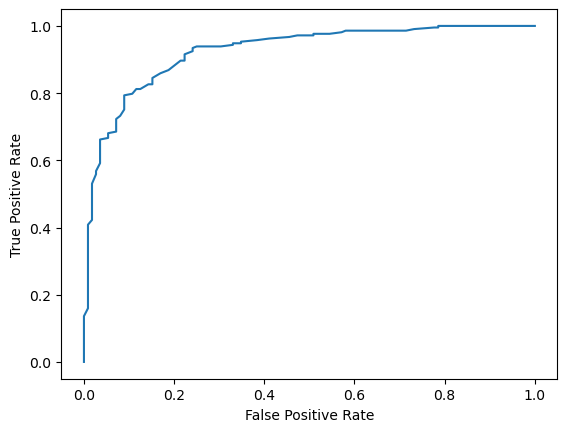

In [10]:
#model_rf = rf.fit(x_train, y_train)
y_pred_rf = ros_model.predict_proba(x_val)
#auc_rf = roc_auc_score(y_val, y_pred_rf[:,1])
fpr, tpr, _ = roc_curve(y_val,  y_pred_rf[:,1])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# evitar tener mas falsos positivos

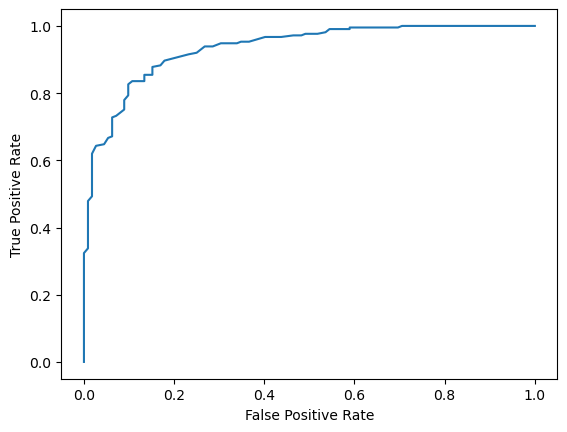

In [11]:
#model_rf = rf.fit(x_train, y_train)
y_pred_xt = xtros_model.predict_proba(x_val)
#auc_rf = roc_auc_score(y_val, y_pred_rf[:,1])
fpr, tpr, _ = roc_curve(y_val,  y_pred_xt[:,1])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# evitar tener mas falsos positivos

### Importancia de modelos ExtraTree

In [12]:
## Importancia de variables con xtr
perm_imp = permutation_importance(xtros_model, x_val, y_val, n_repeats=10, scoring='roc_auc')
df_imp = (pd.DataFrame({k:perm_imp[k] for k in ['importances_mean','importances_std']}, index=x_val.columns)
            .sort_values('importances_mean', ascending=False))

df_imp

,importances_mean,importances_std
Grado de Colorante,0.141136,0.020274
Ingrediente_2,0.065983,0.009668
Azucar Gramos,0.030705,0.006289
Gramos entre Azucar y otros endulcorantes,0.017168,0.005544
Litros de Cafeina,0.016094,0.004056
Densidad,0.012787,0.005822
Gramos de aspartamo,0.010731,0.002920
Ingrediente_3,0.010538,0.003799
Ingrediente_1,0.009587,0.003809
Sodio en mg,0.009348,0.004987
